San Francisco Crime Classification

In [63]:
## Setup
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns    
    import xgboost as xgb
except ImportError:
    print("Installing libs...")
    import subprocess
    subprocess.check_call(["pip", "install", "xgboost"])
    subprocess.check_call(["pip", "install", "pandas"])
    subprocess.check_call(["pip", "install", "numpy"])
    subprocess.check_call(["pip", "install", "matplotlib"])
    subprocess.check_call(["pip", "install", "seaborn"])
    subprocess.check_call(["pip", "install", "scikit-learn"])
    

In [64]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings

from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer

## Evaluation metrics
from sklearn.metrics import (accuracy_score, f1_score, log_loss, mean_squared_error,
                            confusion_matrix, ConfusionMatrixDisplay, 
                            classification_report, roc_curve, auc)

# Part 1: Data Loading and Preprocessing

## Load Data Function

In [65]:
def load_data():
    "Load San Francisco crime data "
    try:
        train = pd.read_csv('data/train.csv.zip')
        test = pd.read_csv('data/test.csv.zip')
    except FileNotFoundError:        
        print("Dataset not found.")
    
    print("Data loaded from local files")
    return train, test

load_data()



Data loaded from local files


(                      Dates                Category  \
 0       2015-05-13 23:53:00                WARRANTS   
 1       2015-05-13 23:53:00          OTHER OFFENSES   
 2       2015-05-13 23:33:00          OTHER OFFENSES   
 3       2015-05-13 23:30:00           LARCENY/THEFT   
 4       2015-05-13 23:30:00           LARCENY/THEFT   
 ...                     ...                     ...   
 878044  2003-01-06 00:15:00                 ROBBERY   
 878045  2003-01-06 00:01:00           LARCENY/THEFT   
 878046  2003-01-06 00:01:00           LARCENY/THEFT   
 878047  2003-01-06 00:01:00               VANDALISM   
 878048  2003-01-06 00:01:00  FORGERY/COUNTERFEITING   
 
                                          Descript  DayOfWeek PdDistrict  \
 0                                  WARRANT ARREST  Wednesday   NORTHERN   
 1                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
 2                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
 3                    

### Preprocessing Function

In [ ]:
def preprocess(data):
    """
    Comprehensive preprocessing with NaN handling
    - Removes invalid coordinates (0,0)
    - Extracts temporal features from datetime
    - Handles missing values with median imputation
    """
    print(f"Initial data shape: {data.shape}")
    
    # Identify invalid coordinates (0,0) and the extreme outlier (Y >= 90.0)
    outlier_mask = (data['X'] == 0) | (data['Y'] == 0) | (data['Y'] >= 90.0)
    
    # Replace the X and Y values in these outlier rows with NaN to replace with the median later.
    data.loc[outlier_mask, ['X', 'Y']] = np.nan

    print(f"After marking {outlier_mask.sum()} outliers as NaN: {data.shape}")

    # Define the center coordinates for the Tenderloin district (approximate center)
    TENDERLOIN_X_CENTER = -122.41
    TENDERLOIN_Y_CENTER = 37.783

    # 1. Calculate Radial Feature (Distance from Tenderloin)
    data['Distance_Tenderloin'] = np.sqrt(
        (data['X'] - TENDERLOIN_X_CENTER)**2 + 
        (data['Y'] - TENDERLOIN_Y_CENTER)**2
    )

    # 2. Create Rounded Categorical Features (for granularity)
    # Use rounding to create 'micro-neighborhood' categorical features.
    # Use slightly different rounding levels (3 or 4 decimals) for greater distinction.

    # Rounded to 3 decimals 
    data['X_RND3'] = data['X'].round(3) #approx. 100 meter resolution
    data['Y_RND3'] = data['Y'].round(3)

    # Rounded to 2 decimals 
    data['X_RND2'] = data['X'].round(2) #approx. 1 km resolution
    data['Y_RND2'] = data['Y'].round(2)

    # 3. Create Interaction Feature
    data['XY_Interaction'] = data['X'] * data['Y']

    # # Correct filter for the SF Crime dataset
    # data = data[data['Y'] < 90.0]
    
    print(f"After removing invalid coordinates: {data.shape}")
    
    # Extract datetime features
    data['Dates'] = pd.to_datetime(data['Dates'])
    data['Year'] = data['Dates'].dt.year
    data['Month'] = data['Dates'].dt.month
    data['Day'] = data['Dates'].dt.day
    data['Hour'] = data['Dates'].dt.hour

    # --- 1. TimeOfDay Feature ---
    # Use pd.cut to bin the 'Hour' column
    hour_bins = [-1, 6, 12, 18, 23]  # Bins: (Night, Morning, Afternoon, Evening)
    hour_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
    data['TimeOfDay'] = pd.cut(data['Hour'], bins=hour_bins, labels=hour_labels)

    # --- 2. Interaction Feature ---
    # This combines two categorical features into one

    
    data['Day_Area_Interaction'] = data['DayOfWeek'] + '_' + data['PdDistrict']

    # --- 3. AreaType Feature ---
    # Define the districts that make up the "downtown" core
    # downtown_districts = [
    #     'SOUTHERN',   # Covers SoMa, FiDi, Mission Bay
    #     'CENTRAL',    # Covers Chinatown, FiDi, Nob Hill
    #     'TENDERLOIN' # Covers Tenderloin, Civic Center
    # ]

    # --- 4. AreaType Feature ---
    # If the district is in our list, label 'downtown', otherwise 'suburban'.
    # data['AreaType'] = data['PdDistrict'].apply(
    #     lambda district: 'downtown' if district in downtown_districts else 'suburban'
    # )
    
    
    # --- 5. IsNight Feature ---
    # A simple binary based on the new TimeOfDay
    # data['IsNight'] = (data['TimeOfDay'] == 'Night').astype(int)
    
    # --- 6. IsWeekend Feature ---
    # The DayOfWeek column is a string; .isin() is perfect for this
    # data['IsWeekend'] = data['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)


    return data


### Feature Encoding Function

In [ ]:
def encode_features(df, numerical_cols):
    """
    One-hot encode categorical features and combine with numerical
    """
    # day_dummies = pd.get_dummies(df['DayOfWeek'], prefix='Day')
    # area_dummies = pd.get_dummies(df['AreaType'], prefix='Area')
    # binary_features = df[['IsWeekend', 'IsNight']]
    district_dummies = pd.get_dummies(df['PdDistrict'], prefix='District')
    time_of_day_dummies = pd.get_dummies(df['TimeOfDay'], prefix='Time')
    day_area_dummies = pd.get_dummies(df['Day_Area_Interaction'], prefix='DayArea')

    # --- Numerical and Binary ---
    numerical = df[numerical_cols]

    # --- FIX 1: LABEL ENCODE ROUNDED COORDINATES ---
    categorical_XY = [
        'X_RND3', 'Y_RND3', 
        'X_RND2', 'Y_RND2',
    ]
    
    le = LabelEncoder()
    # Create a new DataFrame for the encoded XY features
    categorical_XY_encoded = pd.DataFrame() 
    
    for col in categorical_XY:
        # Fill NaN/missing values before encoding if any remain
        df[col] = df[col].fillna(df[col].mode()[0]) 
        # Convert float to string to ensure LabelEncoder treats them as discrete categories
        categorical_XY_encoded[col + '_LE'] = le.fit_transform(df[col].astype(str))
    
    # Drop the raw X/Y coordinates from the numerical list before concatenation
    if 'X' in numerical.columns: numerical = numerical.drop(columns=['X', 'Y'])
    
    return pd.concat([
        categorical_XY_encoded, 
        numerical,
        district_dummies,
        time_of_day_dummies,
        day_area_dummies
    ], axis=1)

### Execute Preprocessing and Splitting

In [178]:
#Loads the data, applies all preprocessing steps, handles missing values, encodes the target variable, and splits the data into training and validation sets.
print(" Loading and preprocessing data...")
train, test = load_data()
train = preprocess(train)

# Handle missing values in numerical columns
numerical_cols = ['X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'XY_Interaction', 'Distance_Tenderloin']

# This step now handles outliers you marked as NaN for X,Y.
imputer = SimpleImputer(strategy='median')
train[numerical_cols] = imputer.fit_transform(train[numerical_cols])

imputer = SimpleImputer(strategy='median')
train[numerical_cols] = imputer.fit_transform(train[numerical_cols])

# Encode target variable
le = LabelEncoder()
y_train = le.fit_transform(train['Category']) # categories like 'LARCENY/THEFT','VANDALISM','ASSAULT', etc.
print(f"Number of crime categories: {len(le.classes_)}")

# Feature engineering
X_train = encode_features(train, numerical_cols)
print(f"Feature matrix shape: {X_train.shape}")

# Show all columns when printing (no truncation)
pd.set_option('display.max_columns', None)
print("Columns in encoded X_train:")
print(list(X_train.columns))

print("First 10 rows after encoding (full columns):")
print(X_train.head(10).to_string())

# Also show original train columns for reference
print("Original train columns:")
print(list(train.columns))

# Train-validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

 Loading and preprocessing data...
Data loaded from local files
Initial data shape: (878049, 9)
After marking 67 outliers as NaN: (878049, 9)
After removing invalid coordinates: (878049, 15)
Number of crime categories: 39
Feature matrix shape: (878049, 94)
Columns in encoded X_train:
['X_RND3_LE', 'Y_RND3_LE', 'X_RND2_LE', 'Y_RND2_LE', 'Year', 'Month', 'Day', 'Hour', 'XY_Interaction', 'Distance_Tenderloin', 'District_BAYVIEW', 'District_CENTRAL', 'District_INGLESIDE', 'District_MISSION', 'District_NORTHERN', 'District_PARK', 'District_RICHMOND', 'District_SOUTHERN', 'District_TARAVAL', 'District_TENDERLOIN', 'Time_Night', 'Time_Morning', 'Time_Afternoon', 'Time_Evening', 'DayArea_Friday_BAYVIEW', 'DayArea_Friday_CENTRAL', 'DayArea_Friday_INGLESIDE', 'DayArea_Friday_MISSION', 'DayArea_Friday_NORTHERN', 'DayArea_Friday_PARK', 'DayArea_Friday_RICHMOND', 'DayArea_Friday_SOUTHERN', 'DayArea_Friday_TARAVAL', 'DayArea_Friday_TENDERLOIN', 'DayArea_Monday_BAYVIEW', 'DayArea_Monday_CENTRAL', 'Da

<Axes: xlabel='X', ylabel='Y'>

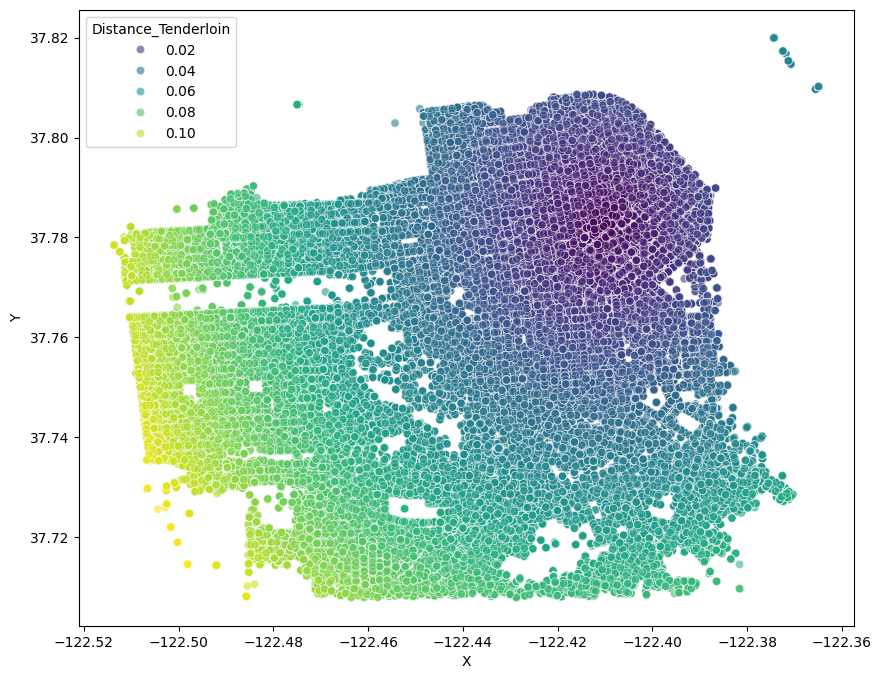

In [192]:
#generate a visualization of feature Distance_Tenderloin on a map of San Francisco
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=train, x='X', y='Y', 
    hue='Distance_Tenderloin', 
    palette='viridis', 
    alpha=0.6
)

# Part 2: Model Training

### Random Forest Classifier

In [181]:
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=1, max_depth=8, n_jobs=-1, random_state=42)
rf.fit(X_train_split, y_train_split)

Training Random Forest...


,n_estimators,1
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### XGBoost Classifier

In [ ]:
#Trains an XGBoost classifier, optimized for multi-class classification using 'multi:softprob'.
print("Training XGBoost...")
# Prepare validation set for monitoring
eval_set = [(X_val_split, y_val_split)]

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=39,                
    eval_metric='mlogloss',    
    n_estimators=1100,              
    max_depth=8,                     
    learning_rate=0.05,              
    subsample=0.9,                   # added slightly higher subsample
    colsample_bytree=0.85,           # 0.8–0.9 is ideal
    colsample_bylevel=0.85,          
    min_child_weight=5,              # prevents overfitting on rare classes
    gamma=0.1,                       # small regularization    
    max_delta_step=1,                # helps with imbalanced classes
    reg_alpha=0.1,                   # L1 regularization
    reg_lambda=1.0,                  # L2 regularization    
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    tree_method='hist',        
    seed=42                         
)

xgb_model.fit(
        X_train_split, y_train_split,
        eval_set=eval_set,
        verbose=False)


Training XGBoost...


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.85
,colsample_bynode,None
,colsample_bytree,0.85
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


Training XGBoost with Log Loss Optimization...

--- Iteration 1/5 ---
Log Loss: 2.630990 | Time: 782.81s
✓ New best! Log Loss improved to 2.630990

--- Iteration 2/5 ---
Log Loss: 2.630692 | Time: 931.39s
✓ New best! Log Loss improved to 2.630692

--- Iteration 3/5 ---
Log Loss: 2.631015 | Time: 537.28s
No improvement. Patience: 1/3

--- Iteration 4/5 ---
Log Loss: 2.630759 | Time: 609.27s
No improvement. Patience: 2/3

--- Iteration 5/5 ---
Log Loss: 2.630889 | Time: 151.88s
No improvement. Patience: 3/3

Early stopping: No improvement for 3 iterations

FINAL RESULTS:
Best Log Loss: 2.630692
Iterations completed: 5
Log Loss History: ['2.630990', '2.630692', '2.631015', '2.630759', '2.630889']


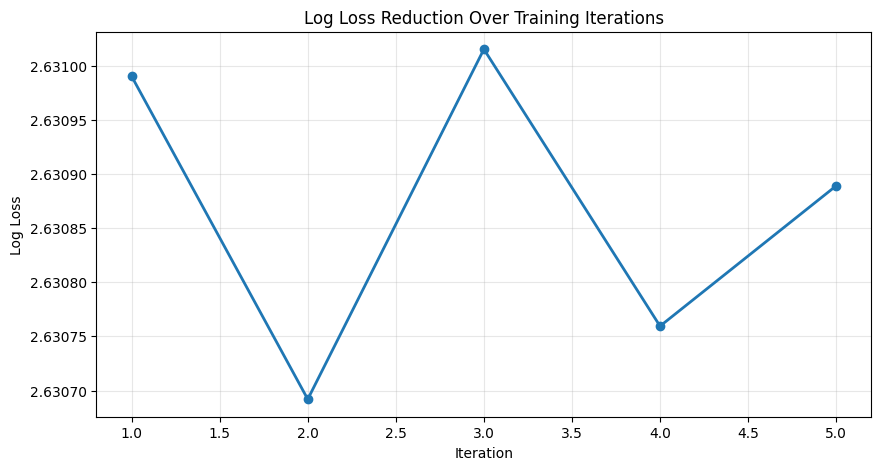

In [191]:
import time

print("Training XGBoost with Log Loss Optimization...")
print("=" * 70)

# Initialize tracking variables
best_logloss = float('inf')
best_model = None
logloss_history = []
patience = 3  # Stop if no improvement for 3 iterations
patience_counter = 0

# Prepare validation set for monitoring
eval_set = [(X_val_split, y_val_split)]

# Try multiple training iterations with different random seeds
for iteration in range(5):
    print(f"\n--- Iteration {iteration + 1}/5 ---")
    start_time = time.time()
    
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        n_estimators=100,          
        max_depth=6,                
        learning_rate=0.02,         
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42 + iteration, 
        eval_metric='mlogloss',
        early_stopping_rounds=25,   
        verbosity=0,
        n_jobs=-1)
    
    # Train with early stopping
    xgb_model.fit(
        X_train_split, y_train_split,
        eval_set=eval_set,
        verbose=False)
    
    # Calculate validation log loss
    val_proba = xgb_model.predict_proba(X_val_split)
    current_logloss = log_loss(y_val_split, val_proba)
    logloss_history.append(current_logloss)
    
    training_time = time.time() - start_time
    print(f"Log Loss: {current_logloss:.6f} | Time: {training_time:.2f}s")
    
    # Track best model
    if current_logloss < best_logloss:
        best_logloss = current_logloss
        best_model = xgb_model
        patience_counter = 0
        print(f"✓ New best! Log Loss improved to {best_logloss:.6f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
    
    # Early stopping if no improvement
    if patience_counter >= patience:
        print(f"\nEarly stopping: No improvement for {patience} iterations")
        break

# Use best model
xgb_model = best_model

# Train with early stopping
xgb_model.fit(
    X_train_split, y_train_split,
    eval_set=eval_set,
    verbose=False)

print("\n" + "=" * 70)
print(f"FINAL RESULTS:")
print(f"Best Log Loss: {best_logloss:.6f}")
print(f"Iterations completed: {len(logloss_history)}")
print(f"Log Loss History: {[f'{x:.6f}' for x in logloss_history]}")
print("=" * 70)

# Plot log loss improvement
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(logloss_history) + 1), logloss_history, marker='o', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Log Loss Reduction Over Training Iterations')
plt.grid(True, alpha=0.3)
plt.show()

### Calibrated SVM Classifier

In [ ]:
# #Trains an SVM classifier (using SGDClassifier for efficiency) and calibrates it using `CalibratedClassifierCV` to produce reliable probabilities. This requires scaling the data.
# print("Training Calibrated SVM...")
# scaler = StandardScaler()
# X_train_svm = X_train_split.copy()
# X_train_svm[numerical_cols] = scaler.fit_transform(X_train_split[numerical_cols])

# svm = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, max_iter=1, 
#                    tol=1e-3, random_state=42, n_jobs=-1)
# calibrated_svm = CalibratedClassifierCV(svm, method='sigmoid', cv=3)
# calibrated_svm.fit(X_train_svm, y_train_split)

# # Prepare validation data for SVM
# X_val_svm = X_val_split.copy()
# X_val_svm[numerical_cols] = scaler.transform(X_val_split[numerical_cols])

# print("All models trained successfully!")

Training Calibrated SVM...


KeyError: "['X', 'Y'] not in index"

# Part 3: Model Evaluation

## Generate Predictions and Calculate Metrics

In [182]:
#Uses the trained models to make predictions on the validation set. Calculates and stores Accuracy, F1-Score, Log-Loss, and RMSE for each model.
print("\nGenerating predictions and calculating metrics...")

# Generate predictions
rf_pred = rf.predict(X_val_split)
xgb_pred = xgb_model.predict(X_val_split)
# svm_pred = calibrated_svm.predict(X_val_svm)

# Generate predicted probabilities
rf_proba = rf.predict_proba(X_val_split)
xgb_proba = xgb_model.predict_proba(X_val_split)
# svm_proba = calibrated_svm.predict_proba(X_val_svm)

# Calculate all metrics
models = ['Random Forest', 'XGBoost']
predictions = [rf_pred, xgb_pred]
probabilities = [rf_proba, xgb_proba]

metrics_results = {}
for model, pred, proba in zip(models, predictions, probabilities):
    metrics_results[model] = {
        'Accuracy': accuracy_score(y_val_split, pred),
        'F1-Score': f1_score(y_val_split, pred, average='weighted'),
        'Log-Loss': log_loss(y_val_split, proba),
        'RMSE': np.sqrt(mean_squared_error(y_val_split, pred))
    }


Generating predictions and calculating metrics...


# Part 4: Comprehensive Visualizations

## 4.1 Metrics Comparison Bar Plot

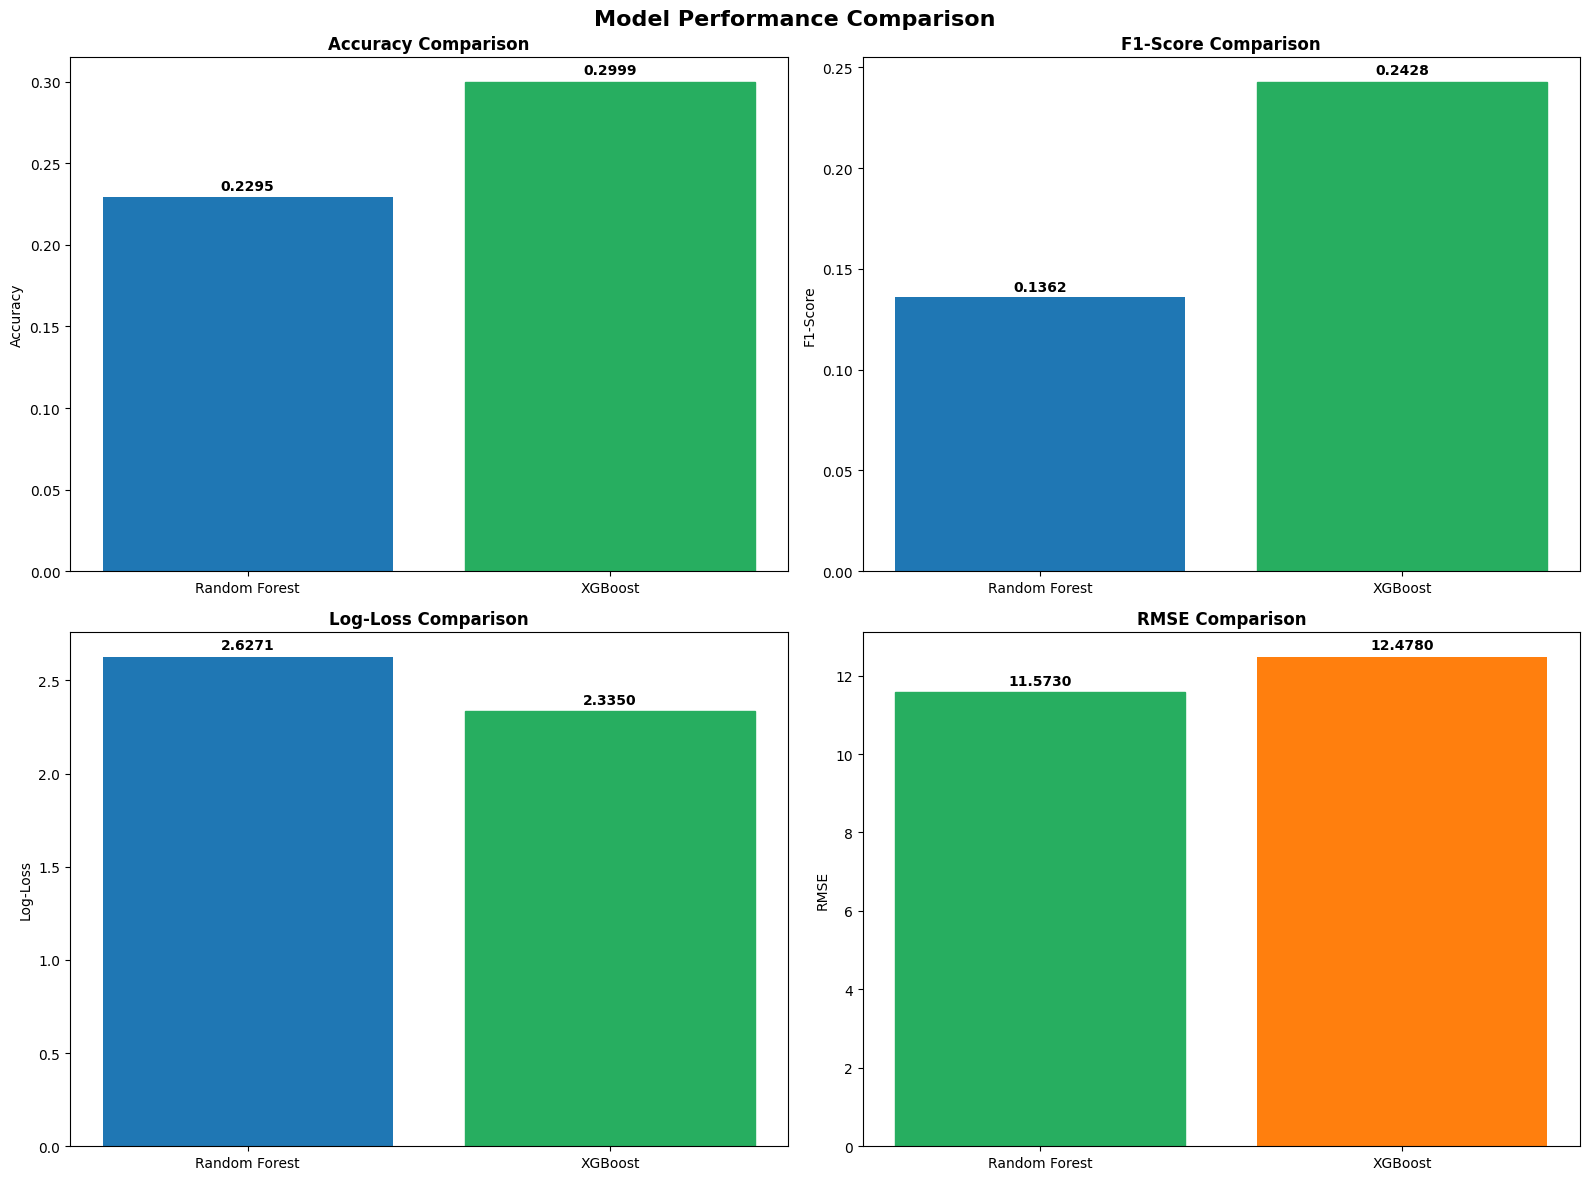

In [183]:
#Compares all models across the four key metrics: Accuracy, F1-Score, Log-Loss, and RMSE.
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'F1-Score', 'Log-Loss', 'RMSE']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    values = [metrics_results[model][metric] for model in models]
    
    bars = ax.bar(models, values, color=colors)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_ylabel(metric)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # For log-loss and RMSE, lower is better - highlight the best
    if metric in ['Log-Loss', 'RMSE']:
        best_idx = np.argmin(values)
    else:
        best_idx = np.argmax(values)
    bars[best_idx].set_color('#27ae60')

plt.tight_layout()
plt.show()

### 4.2 Matrices Comparison

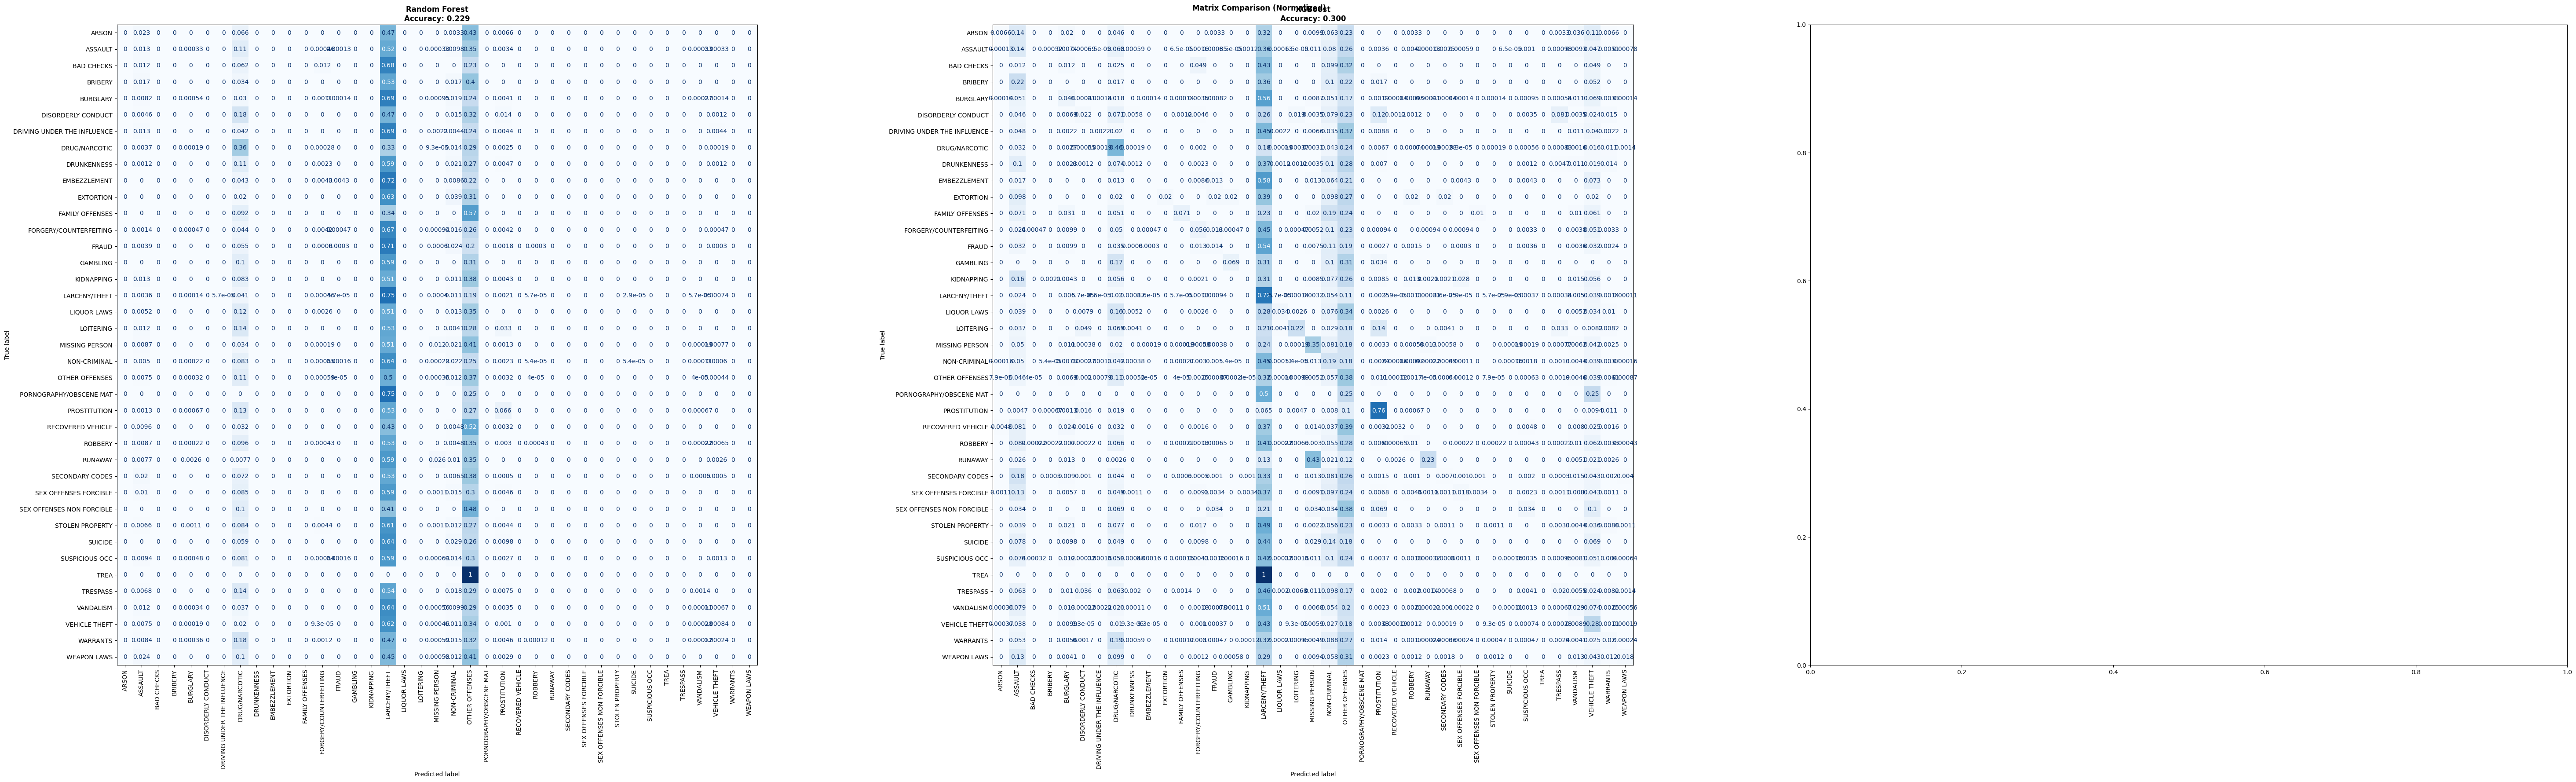

In [184]:
#Plots normalized confusion matrices for each model to visualize per-class performance and identify common misclassifications.
fig, axes = plt.subplots(1, 3, figsize=(60,18))
fig.suptitle('Matrix Comparison (Normalized)', fontsize=12, fontweight='bold')


for i, (model, pred) in enumerate(zip(models, predictions)):
    cm = confusion_matrix(y_val_split, pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=axes[i], xticks_rotation=90, colorbar=False, cmap='Blues')
    axes[i].set_title(f'{model}\nAccuracy: {metrics_results[model]["Accuracy"]:.3f}', 
                     fontweight='bold')
    

plt.tight_layout()
plt.show()    

### 4.3 ROC Curves (One-vs-Rest)

Generating ROC curves...


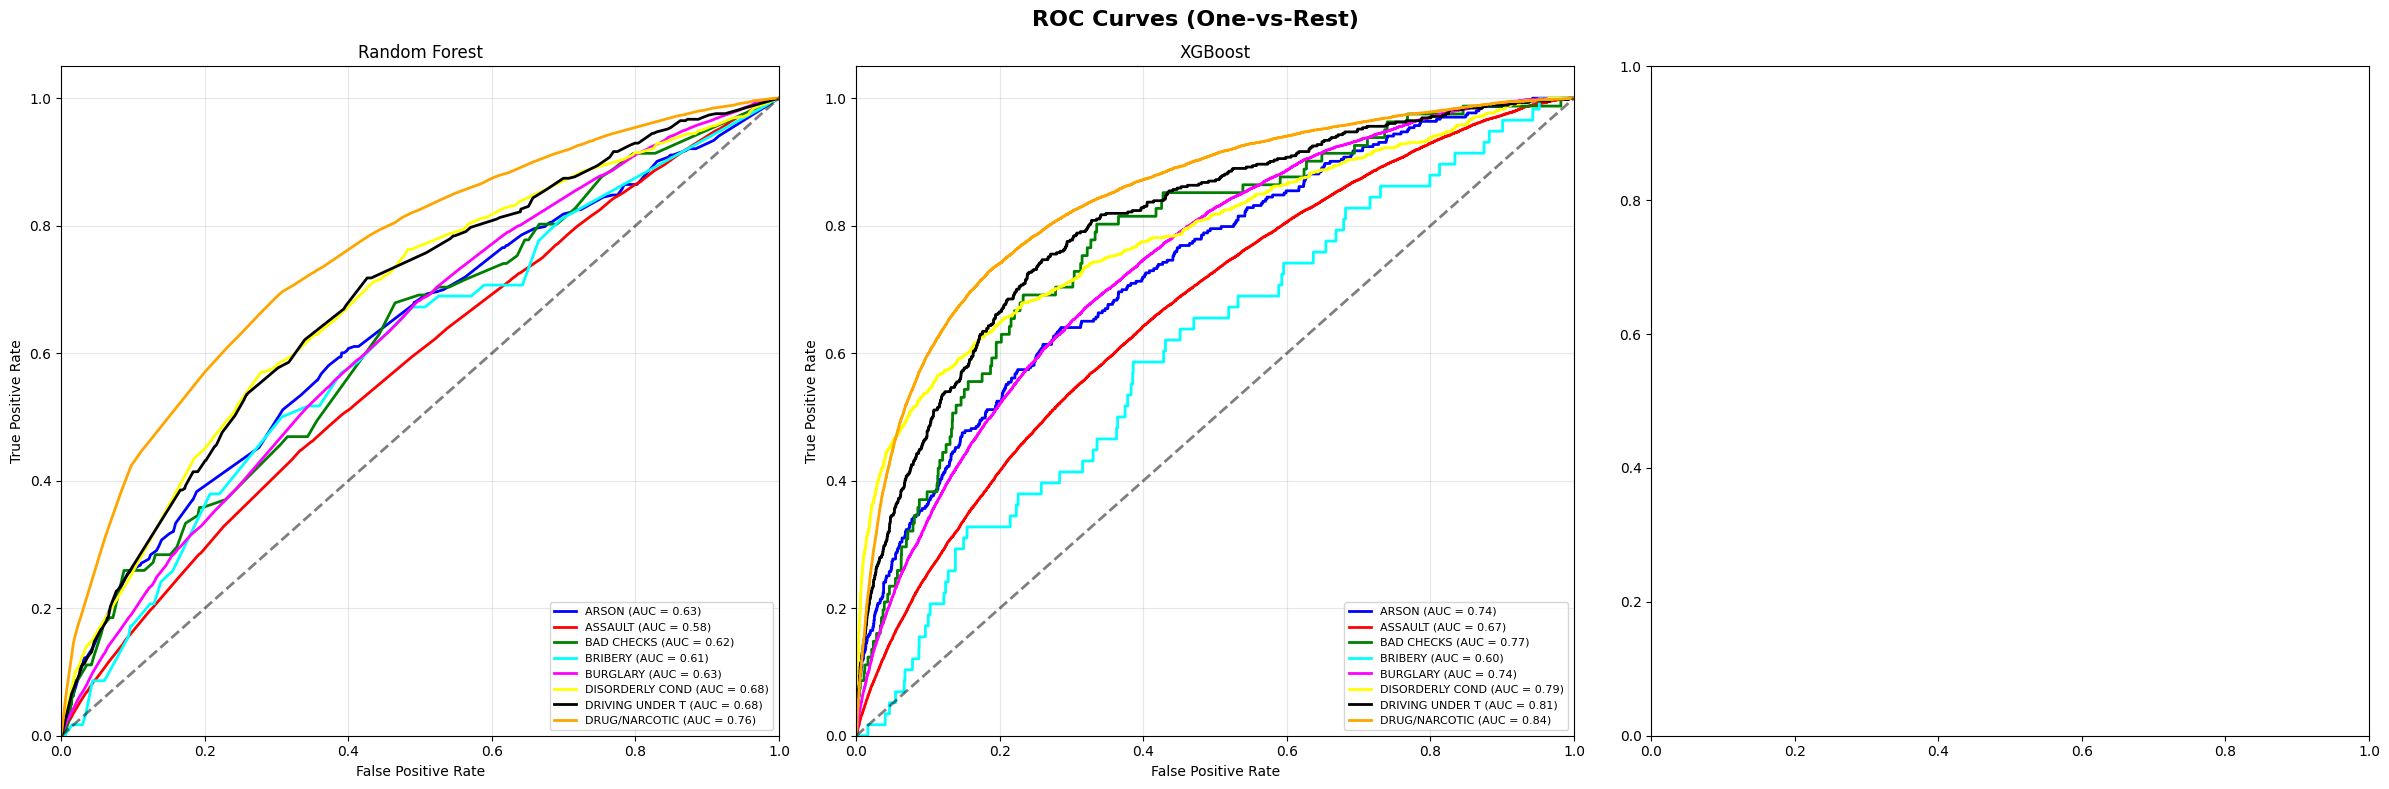

In [185]:
#Generates multiclass One-vs-Rest (OvR) ROC curves to evaluate the trade-off between true positive rate and false positive rate for each class.
print("Generating ROC curves...")
# Binarize labels for ROC calculation
label_binarizer = LabelBinarizer()
y_val_bin = label_binarizer.fit_transform(y_val_split)
n_classes = y_val_bin.shape[1]


fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('ROC Curves (One-vs-Rest)', fontsize=16, fontweight='bold')
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange'])


for idx, (model, proba) in enumerate(zip(models, probabilities)):
    ax = axes[idx]
    
    # Calculate ROC for each class
    for i, color in zip(range(min(n_classes, 8)), colors):  # Limit to 8 classes for visibility
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, color=color, lw=2,
                label=f'{le.classes_[i][:15]} (AUC = {roc_auc:.2f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model}')
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()    

### 4.4 Feature Importance

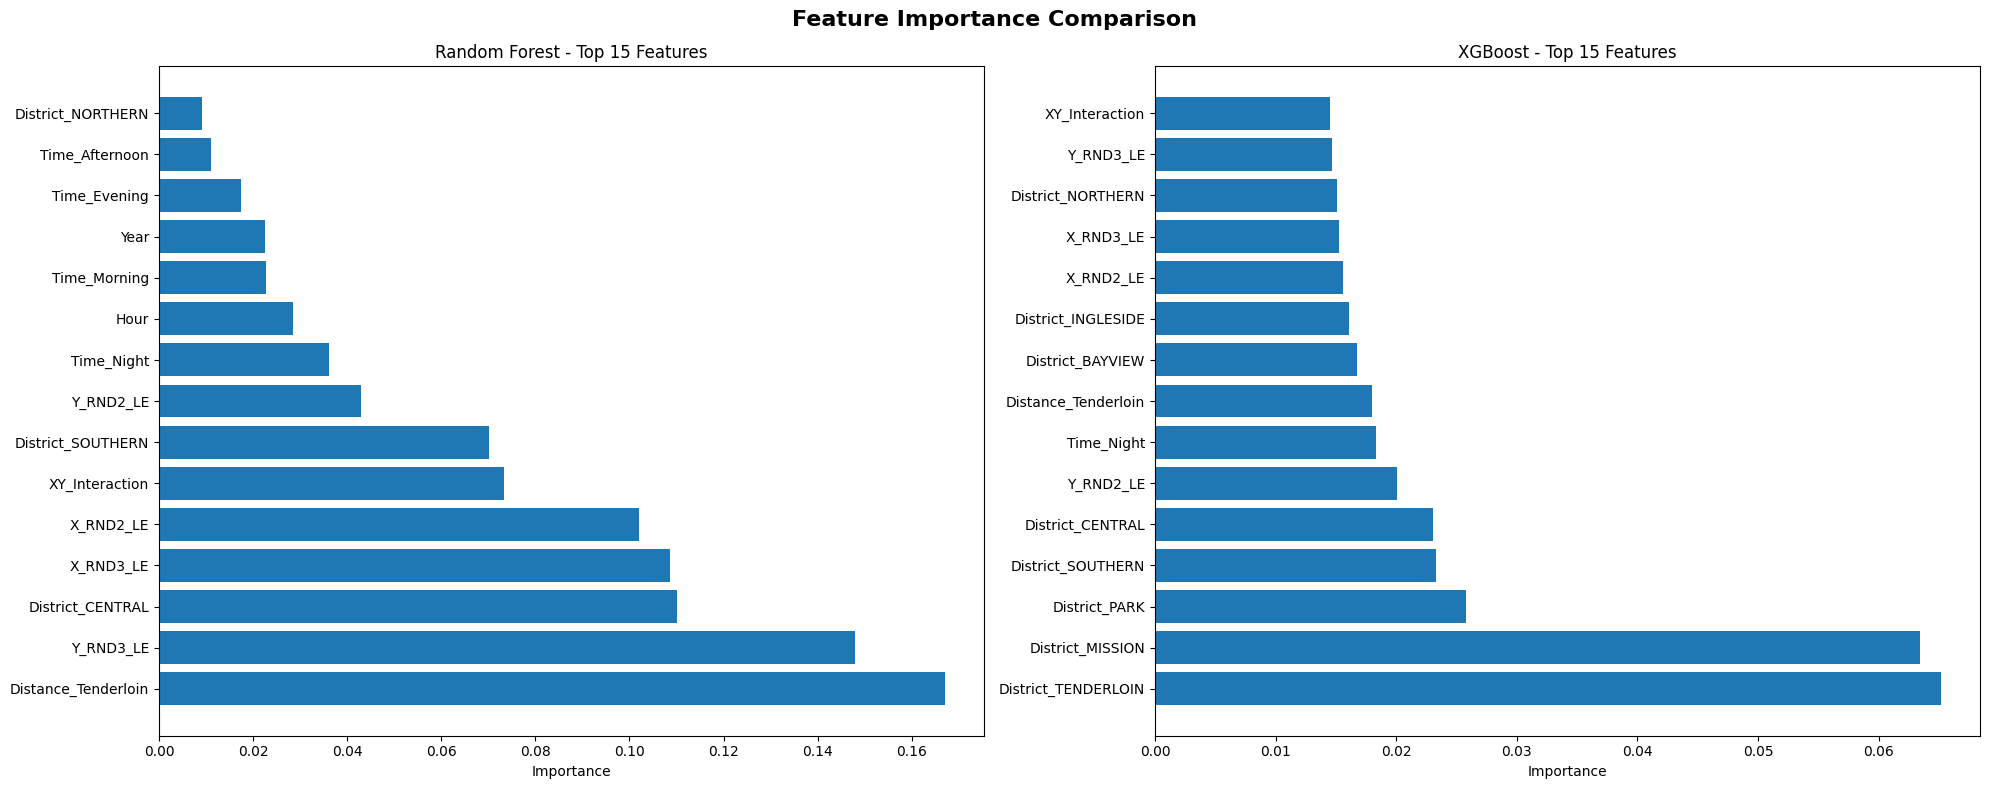

In [186]:
#Compares the top 15 features as determined by the tree-based models (Random Forest and XGBoost) to understand what features drive the predictions.
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Feature Importance Comparison', fontsize=16, fontweight='bold')

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_}).sort_values('importance', ascending=False).head(15)
axes[0].barh(rf_importance['feature'], rf_importance['importance'])
axes[0].set_title('Random Forest - Top 15 Features')
axes[0].set_xlabel('Importance')

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_}).sort_values('importance', ascending=False).head(15)
axes[1].barh(xgb_importance['feature'], xgb_importance['importance'])
axes[1].set_title('XGBoost - Top 15 Features')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Part 5: Performance Report and Insights

## 5.1 Detailed Performance Report

In [187]:
#Prints a formatted summary table of all evaluation metrics and identifies the best-performing model for each metric.
print("COMPREHENSIVE PERFORMANCE REPORT")

# Print metrics table
print("\n EVALUATION METRICS SUMMARY:")
print("-" * 70)
print(f"{'Model':<15} {'Accuracy':<10} {'F1-Score':<10} {'Log-Loss':<10} {'RMSE':<10}")
print("-" * 70)
for model in models:
    metrics = metrics_results[model]
    print(f"{model:<15} {metrics['Accuracy']:<10.4f} {metrics['F1-Score']:<10.4f} "
          f"{metrics['Log-Loss']:<10.4f} {metrics['RMSE']:<10.4f}")
print("-" * 70)

COMPREHENSIVE PERFORMANCE REPORT

 EVALUATION METRICS SUMMARY:
----------------------------------------------------------------------
Model           Accuracy   F1-Score   Log-Loss   RMSE      
----------------------------------------------------------------------
Random Forest   0.2295     0.1362     2.6271     11.5730   
XGBoost         0.2999     0.2428     2.3350     12.4780   
----------------------------------------------------------------------


In [152]:
# Best model identification
best_accuracy = max(models, key=lambda x: metrics_results[x]['Accuracy'])
best_f1 = max(models, key=lambda x: metrics_results[x]['F1-Score'])
best_logloss = min(models, key=lambda x: metrics_results[x]['Log-Loss'])
best_rmse = min(models, key=lambda x: metrics_results[x]['RMSE'])

print(f"\n BEST PERFORMERS:")
print(f"   Best Accuracy:  {best_accuracy} ({metrics_results[best_accuracy]['Accuracy']:.4f})")
print(f"   Best F1-Score:  {best_f1} ({metrics_results[best_f1]['F1-Score']:.4f})")
print(f"   Best Log-Loss:  {best_logloss} ({metrics_results[best_logloss]['Log-Loss']:.4f})")
print(f"   Best RMSE:      {best_rmse} ({metrics_results[best_rmse]['RMSE']:.4f})")



 BEST PERFORMERS:
   Best Accuracy:  XGBoost (0.2902)
   Best F1-Score:  XGBoost (0.2238)
   Best Log-Loss:  XGBoost (2.3655)
   Best RMSE:      Random Forest (11.3499)


### 5.2 Detailed Classification Reports

In [188]:
#Prints the full classification report (precision, recall, f1-score) for each class, providing a granular look at each model's strengths and weaknesses.
print(f"\n DETAILED CLASSIFICATION REPORTS:")
print("-" * 70)
for model, pred in zip(models, predictions):
    print(f"\n{model.upper()} CLASSIFICATION REPORT:")
    print("-" * 70)
    report = classification_report(y_val_split, pred, target_names=le.classes_, 
                                 output_dict=False, zero_division=0)
    print(report)

#Provides key findings from the analysis and actionable strategies for future improvement.
print(" INSIGHTS AND RECOMMENDATIONS")
print("-" * 70)
print(f"\n COMPETITION CONTEXT:")
if 'Log-Loss' in metrics_results[best_logloss]:
    logloss_score = metrics_results[best_logloss]['Log-Loss']
    if logloss_score < 2.3:
        print(f"   Excellent! Score of {logloss_score:.3f} is competitive (top 10%)")
    elif logloss_score < 2.4:
        print(f"   Good! Score of {logloss_score:.3f} is above average")
    else:
        print(f"   Score of {logloss_score:.3f} needs improvement for competition")

print("-" * 70)
print("ANALYSIS COMPLETE")


 DETAILED CLASSIFICATION REPORTS:
----------------------------------------------------------------------

RANDOM FOREST CLASSIFICATION REPORT:
----------------------------------------------------------------------
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.15      0.01      0.02     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.09      0.00      0.00      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.24      0.36      0.28     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTI

KeyError: 2.3820644847331116

# Part 6: Test Set Prediction and Submission

## Prepare Test Data

In [189]:
#Applies the same preprocessing, imputation, and scaling steps to the test dataset to prepare it for prediction.
# --- Prepare test data in the same way as training data ---
# Preprocess test set
test = preprocess(test)
test[numerical_cols] = imputer.transform(test[numerical_cols])
X_test = encode_features(test, numerical_cols)

# Ensure columns match between train and test
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# For SVM, scale the numerical columns
# X_test_svm = X_test.copy()
# X_test_svm[numerical_cols] = scaler.transform(X_test_svm[numerical_cols])

Initial data shape: (884262, 7)
After marking 76 outliers as NaN: (884262, 7)
After removing invalid coordinates: (884262, 13)


### Generate Submission File

Selects the final model to submit results into a `submission.csv`.


In [190]:
# --- Choose your model here ---

# Model 1
model = xgb_model
X_test_input = X_test

# Model 2
# model = calibrated_svm
# X_test_input = X_test_svm

# Model 3
# model = rf
# X_test_input = X_test

# --- Generate predicted probabilities ---
probs = model.predict_proba(X_test_input)

# --- Create submission DataFrame ---
submission = pd.DataFrame(probs, columns=le.classes_)
submission.insert(0, 'Id', test['Id'])

# --- Save to CSV for Kaggle submission ---
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!
